<a href="https://colab.research.google.com/github/park-geun-hyeong/Kaggle_project/blob/main/Computer-Vision/Kaggle_Wheat_Detection/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline 

import os
import tqdm
import glob
import cv2
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

##Confirm Data

In [2]:
path = '/content/drive/MyDrive/Kaggle/Computer_Vision/Kaggle_wheat_detection/'

submission = pd.read_csv(path+'sample_submission.csv')
train = pd.read_csv(path+'train.csv')
train_img = os.listdir(path+'train')
test_img = os.listdir(path+'test')

In [3]:
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [4]:
submission.head()

image_id PredictionString
0  aac893a91    1.0 0 0 50 50
1  51f1be19e    1.0 0 0 50 50
2  f5a1f0358    1.0 0 0 50 50
3  796707dd7    1.0 0 0 50 50
4  51b3e36ab    1.0 0 0 50 50

In [5]:
print('num of train_img: {}'.format(len(train_img)))
print('num of test_img: {}'.format(len(test_img)))

num of train_img: 3422
num of test_img: 10


## Make new DataFrame

In [6]:
all_train_image = pd.DataFrame([fns.split('/')[-1][:-4] for fns in train_img])
all_train_image.columns=['image_id']

In [7]:
all_train_image = all_train_image.merge(train, on='image_id', how='left')

In [8]:
all_train_image

image_id   width  height                          bbox     source
0       b58605092  1024.0  1024.0   [378.0, 59.0, 119.0, 108.0]  arvalis_2
1       b58605092  1024.0  1024.0   [560.0, 458.0, 118.0, 97.0]  arvalis_2
2       b58605092  1024.0  1024.0  [227.0, 371.0, 126.0, 105.0]  arvalis_2
3       b58605092  1024.0  1024.0    [253.0, 665.0, 92.0, 92.0]  arvalis_2
4       b58605092  1024.0  1024.0   [587.0, 860.0, 89.0, 121.0]  arvalis_2
...           ...     ...     ...                           ...        ...
147837  1e2735260  1024.0  1024.0    [965.0, 525.0, 41.0, 41.0]     ethz_1
147838  1e2735260  1024.0  1024.0   [304.0, 161.0, 87.0, 101.0]     ethz_1
147839  1e2735260  1024.0  1024.0    [873.0, 863.0, 46.0, 30.0]     ethz_1
147840  1e2735260  1024.0  1024.0    [207.0, 898.0, 39.0, 36.0]     ethz_1
147841  1e2735260  1024.0  1024.0    [304.0, 589.0, 35.0, 42.0]     ethz_1

[147842 rows x 5 columns]

In [9]:
all_train_image['bbox'] = all_train_image.bbox.fillna('[0,0,0,0]')

In [10]:
bbox_item = all_train_image.bbox.str.split(',', expand=True)
all_train_image['bbox_xmin'] = bbox_item[0].str.strip('[ ').astype(float)
all_train_image['bbox_ymin'] = bbox_item[1].str.strip(' ').astype(float)
all_train_image['bbox_width'] = bbox_item[2].str.strip(' ').astype(float)
all_train_image['bbox_height'] = bbox_item[3].str.strip(' ]').astype(float)

In [11]:
print('num of image without head_detection: {}'.format(len(all_train_image)-len(train)))

num of image without head_detection: 49


## Visualization Wheat_Head_Detection

In [12]:
red=(255,0,0)

def get_all_box(df, image_id):
    image_bboxes = df[df.image_id==image_id]

    bboxes=[]
    for index,row in image_bboxes.iterrows():
        bboxes.append((row.bbox_xmin, row.bbox_ymin, row.bbox_width, row.bbox_height))

    return bboxes

def get_plot_img_example(df):
    fig, axs = plt.subplots(3, 3, figsize=(12,12))
    for row in range(3):
        for col in range(3):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].image_id

            img = cv2.imread(path+'train/'+img_id+'.jpg')
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

            bboxes = get_all_box(df, img_id)

            for bbox in bboxes:
                img = cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3])), color=(255,0,0), thickness=3)

            axs[row, col].imshow(img)

    plt.suptitle("Example")

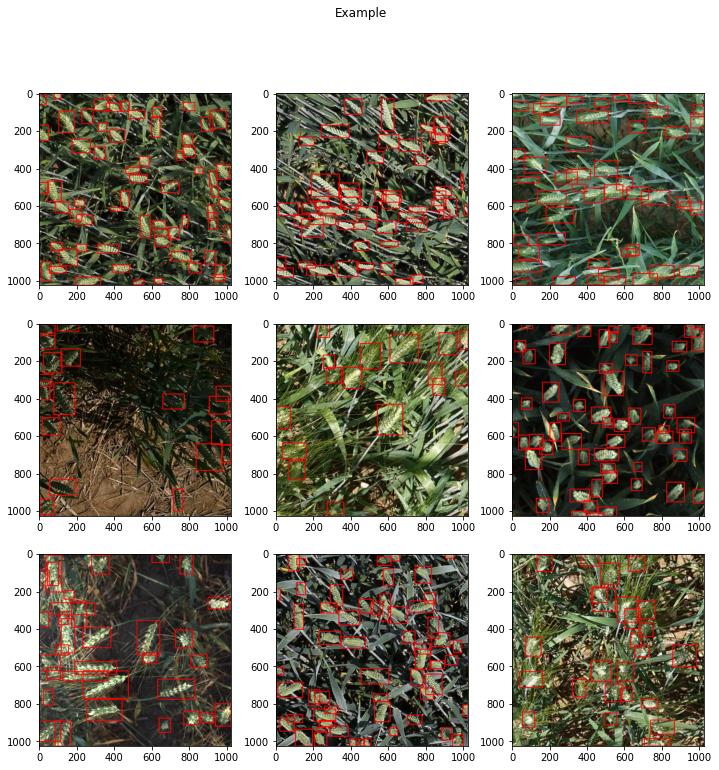

In [13]:
get_plot_img_example(all_train_image)

## Visualization according to count of head_detection 

In [14]:
all_train_image['count'] = all_train_image.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
all_train_count = all_train_image.groupby('image_id').sum().reset_index()   

In [15]:
all_train_count

image_id    width   height  ...  bbox_width  bbox_height  count
0     00333207f  56320.0  56320.0  ...      4792.0       3846.0     55
1     005b0d8bb  20480.0  20480.0  ...      2739.0       2410.0     20
2     006a994f7  25600.0  25600.0  ...      2856.0       2835.0     25
3     00764ad5d  41984.0  41984.0  ...      3951.0       3361.0     41
4     00b5c6764      0.0      0.0  ...         0.0          0.0      0
...         ...      ...      ...  ...         ...          ...    ...
3417  ffbb9c623      0.0      0.0  ...         0.0          0.0      0
3418  ffbf75e5b  53248.0  53248.0  ...      4454.0       4691.0     52
3419  ffbfe7cc0  34816.0  34816.0  ...      2899.0       3040.0     34
3420  ffc870198  41984.0  41984.0  ...      5078.0       3765.0     41
3421  ffdf83e42  39936.0  39936.0  ...      3118.0       2684.0     39

[3422 rows x 8 columns]

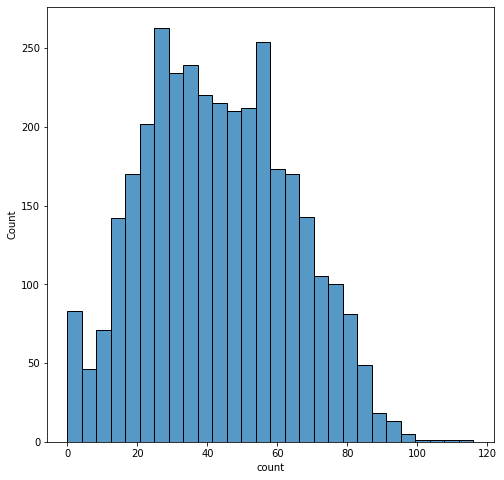

In [16]:
plt.figure(figsize=(8,8))
sns.histplot(all_train_count['count'])
plt.show()

In [17]:
small_head_idx = all_train_count[all_train_count['count']<10]['image_id']

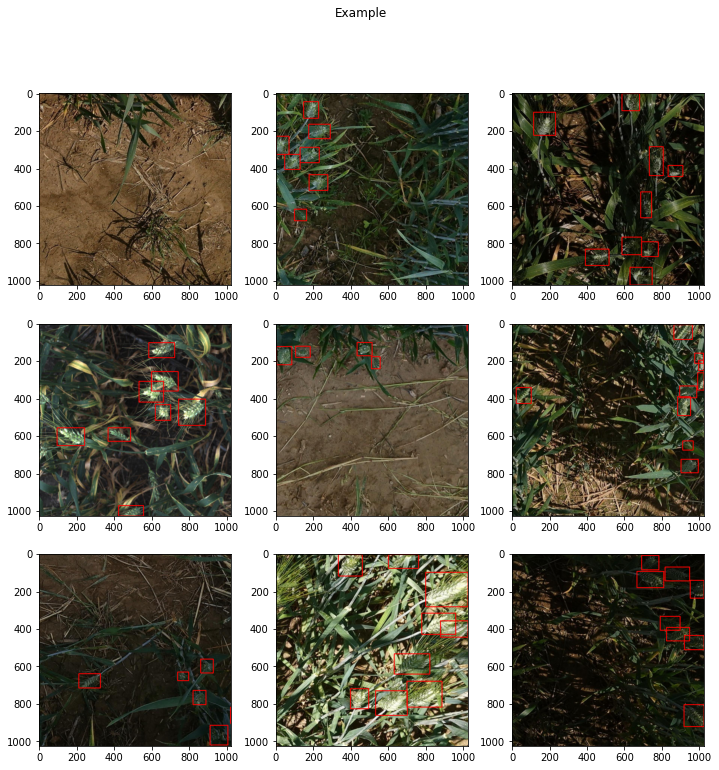

In [18]:
get_plot_img_example(all_train_image[all_train_image.image_id.isin(small_head_idx)])

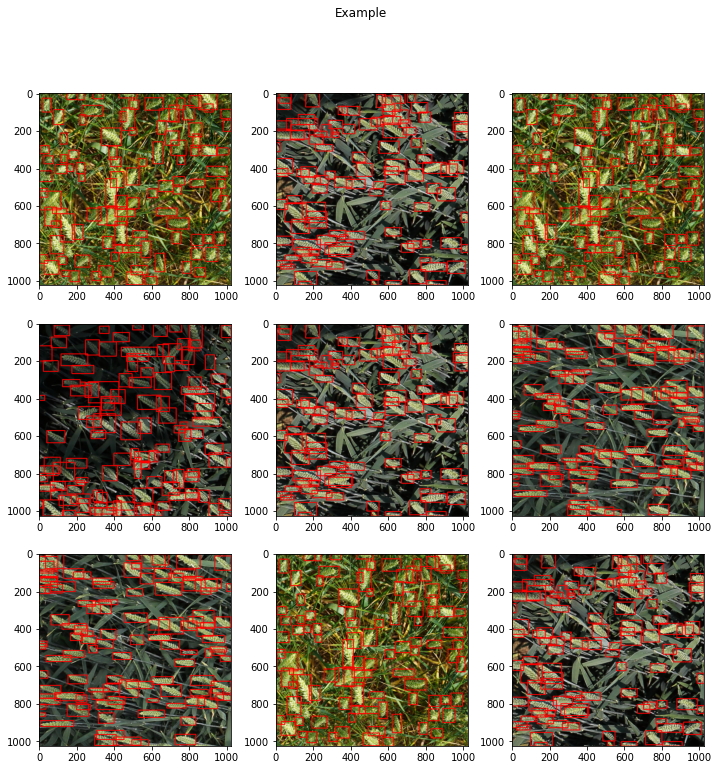

In [19]:
many_head_idx = all_train_count[all_train_count['count']>100]['image_id']

get_plot_img_example(all_train_image[all_train_image.image_id.isin(many_head_idx)])

## Visualization according to area of bbox 

In [20]:
all_train_image['bbox_area'] = round(all_train_image['bbox_width']) * round(all_train_image['bbox_height']) 

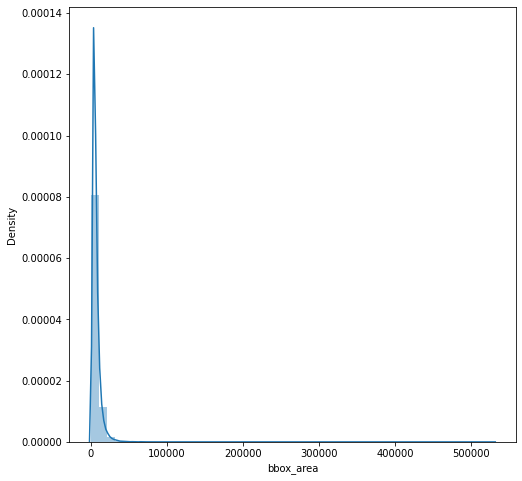

In [21]:
plt.figure(figsize=(8,8))
sns.distplot(all_train_image['bbox_area'])
plt.show()

In [22]:
print('bbox_area_max: {}'.format(all_train_image['bbox_area'].max()))
print('bbox_area_min: {}'.format(all_train_image['bbox_area'].min()))
print('bbox_area_mean: {}'.format(all_train_image['bbox_area'].mean()))


bbox_area_max: 529788.0
bbox_area_min: 0.0
bbox_area_mean: 6841.086633027151


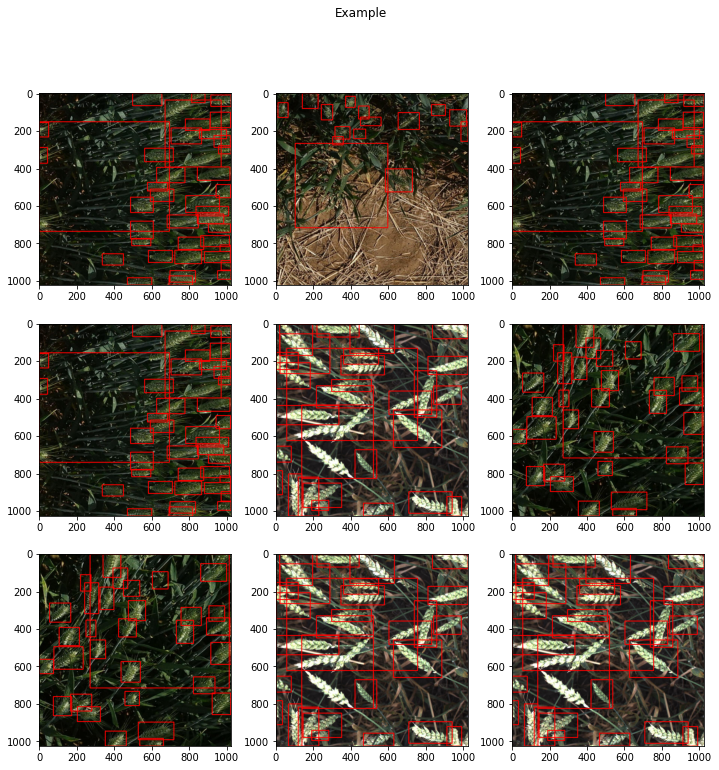

In [25]:
large_bbox_area = all_train_image[all_train_image['bbox_area']>200000]['image_id']
small_bbox_area = all_train_image[all_train_image['bbox_area']<10000]['image_id']


get_plot_img_example(all_train_image[all_train_image.image_id.isin(large_bbox_area)])

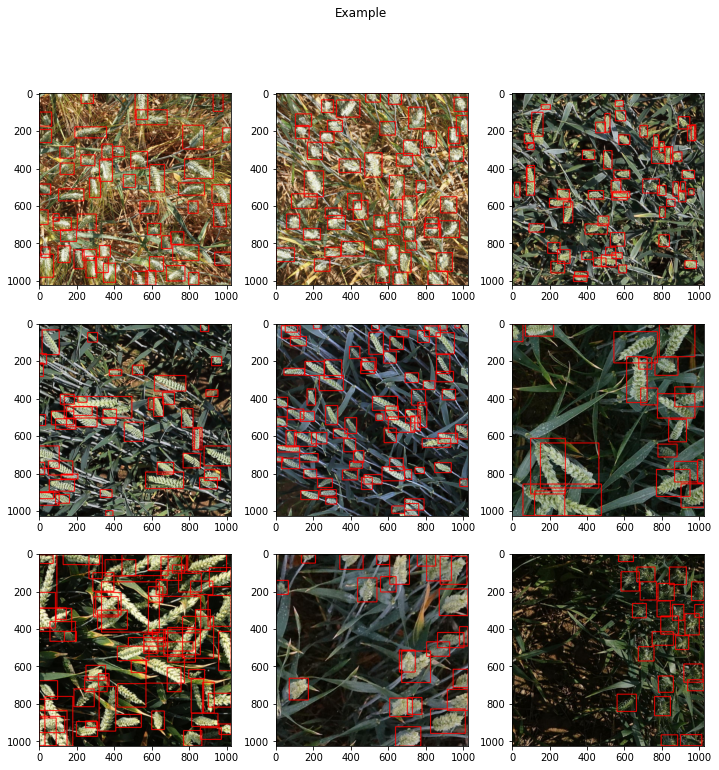

In [26]:
get_plot_img_example(all_train_image[all_train_image.image_id.isin(small_bbox_area)])

## Visualization according to ratio of bbox 

In [28]:
area_bbox = all_train_image.groupby('image_id').sum().reset_index()

In [37]:
area_bbox['percentage of bbox'] = (area_bbox['bbox_area']/1024**2) *100 

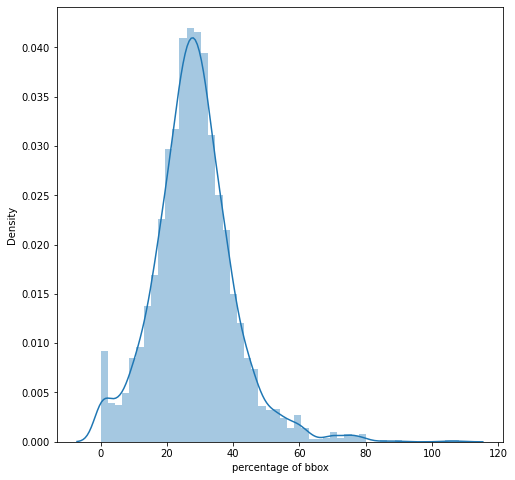

In [38]:
plt.figure(figsize=(8,8)) ## 전체 이미지 크기 1024 x 1024에서 bbox_area가 차지하는 비율 
sns.distplot(area_bbox['percentage of bbox'])
plt.show()

In [39]:
small_percentage = area_bbox[area_bbox['percentage of bbox'] < 5]['image_id']
large_percentage = area_bbox[area_bbox['percentage of bbox'] > 95]['image_id']


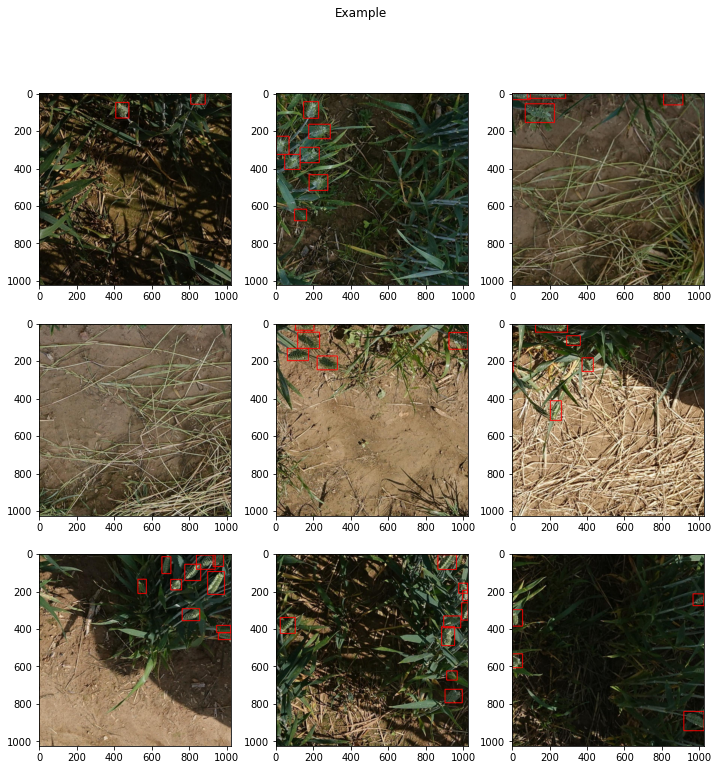

In [40]:
get_plot_img_example(all_train_image[all_train_image.image_id.isin(small_percentage)])

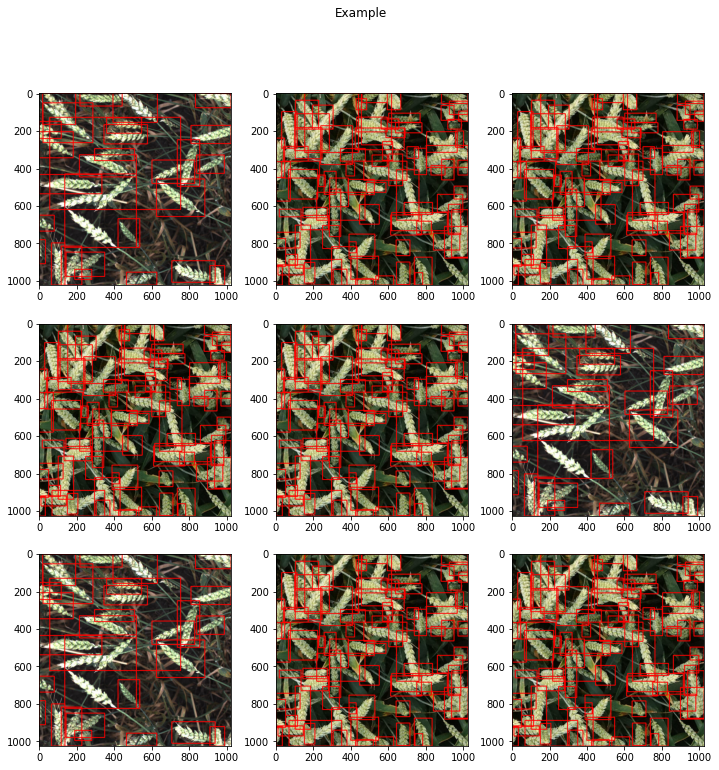

In [41]:
get_plot_img_example(all_train_image[all_train_image.image_id.isin(large_percentage)])

## Visualization according to brightness of image 

In [42]:
def get_image_brightness(image):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return  np.round(np.array(gray_img).mean(),4)

In [43]:
import time
from tqdm import tqdm

def get_bright_image(df):
    brightness=[]

    start=time.time()
    for idx, row in tqdm(df.iterrows()):
        img_id = row.image_id
        image = cv2.imread(path+'train/'+img_id+'.jpg')
        bright = get_image_brightness(image)
        brightness.append(bright) 

    brightness_df = pd.DataFrame(brightness)
    brightness_df.columns=['brightness_image']
    df = pd.concat([df,brightness_df], ignore_index=True, axis=1)
    df.columns=['image_id', 'brightness_image']

    print('time: {}'.format(time.time()-start))

    return df